In [2]:
import sys
sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

from source.common import *
from source.Calibration import CalibrationProblem
from source.DataGenerator import OnePointSpectraDataGenerator

In [3]:
####################################
### Configuration
####################################

config = {
    'type_EddyLifetime' :   'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'hidden_layer_size' :   10,
    # 'nModes'            :   5, ### number of modes in the rational function in tauNet ### deprecated
    'learn_nu'          :   False, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1.e-1,
    'regularization'    :   1.e-1,
    'nepochs'           :   2,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'spectra_file'      :   'Spectra.dat',
    'Uref'              :   8.08, # m/s
    'zref'              :   100, #m
    'domain'            :   np.logspace(-3, 0, 20), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/data/',
    'input_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/script/'
}
pb = CalibrationProblem(**config)

In [15]:
####################################
### Initialize Parameters
####################################

#Calculating turbulence parameters according to IEC standards
# we assume a hub height z=150m corresponding to the IEA 15MW wind turbine hub height
zref=config['zref']; # Hub height in meters
Uref=config['Uref']; # Average Hub height velocity in m/s
Iref = 0.14
sigma1=Iref*(0.75*Uref+5.6)
Lambda1=42; # Longitudinal turbulence scale parameter at hub height


#Mann model parameters
#Gamma = 3.9
#sigma = 0.55*sigma1
#L=0.8*Lambda1;


z0=0.1
ustar=0.41*Uref/log(zref/z0)

L     = 0.59*zref
Gamma = 3.9/L**(2/3)
sigma = 6.4/zref**(2./3.)

sigma = sigma * L**(5./3.)/200

print(L,Gamma,sigma)

parameters = pb.parameters
parameters[:3] = [log(L), log(Gamma), log(sigma)] #All of these parameters are positive 
#so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)


if(config['data_type']=='Custom'):
    if config['spectra_file'] is not None:
        spectra_file=config['spectra_file']
        print('Reading file' + spectra_file + '\n')
        CustomData=np.genfromtxt(spectra_file,skip_header=1,delimiter=',')
        f=CustomData[:,0]
        k1_data_pts=2*np.pi*f/Uref

DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

### Data perturbation
data_noise_magnitude = config['noisy_data']
if data_noise_magnitude:
    Data[1][:] *= np.exp(np.random.normal(loc=0, scale=data_noise_magnitude, size=Data[1].shape))

DataValues = Data[1]

59.0 0.2573336613882325 1.328118005055537
Reading fileSpectra.dat

Reading fileSpectra.dat



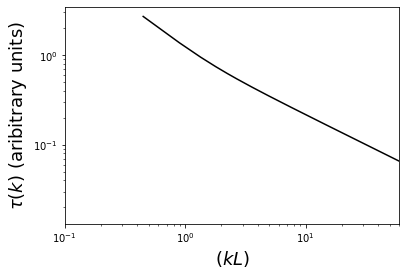

In [12]:
IECtau=MannEddyLifetime(k1_data_pts*L)
plt.figure(1)
plt.loglog(k1_data_pts*L,IECtau,'k')
plt.xlim(0.1,60)
plt.ylabel(r'$\tau(k)$ (aribitrary units)',fontsize=18)
plt.xlabel(r'$(kL)$',fontsize=18)
plt.savefig('tau.png')

In [ ]:
####################################
### Just plot
####################################

kF = pb.eval(k1_data_pts)
plt.figure(1,figsize=(10,10))
clr=['red','blue','green']
for i in range(3):
    plt.plot(k1_data_pts, kF[i], '-', color=clr[i], label=r'$F_{0:d}$ model'.format(i+1))
    plt.plot(k1_data_pts, DataValues[:,i,i], '--',color=clr[i],label=r'$F_{0:d}$ data'.format(i+1) )#, label=r'$F_{0:d}$ data'.format(i+1))
plt.plot(k1_data_pts, -kF[3], '-m', label=r'-$F_{13}$ model')
plt.plot(k1_data_pts, -DataValues[:,0,2], '--m', label=r'$-F_{13}$ data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_1$',fontsize=22)
plt.xlim(0.001,1)
plt.ylim(0.00001,0.01)


plt.ylabel(r'$k_1 F(k_1)/u_\ast^2$',fontsize=22)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(which='both')
plt.show()
plt.savefig(config['output_folder']+'initial_Kaimal_guess.pdf',dpi=100)

In [14]:
####################################
### Calibrate
####################################
opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)


Callibrating MannNet...


KeyboardInterrupt: 

In [ ]:
####################################
### Export
####################################
if 'opt_params' not in locals():
    opt_params = pb.parameters
filename = config['output_folder'] + config['type_EddyLifetime'] + '_' + config['data_type'] + '.pkl'
with open(filename, 'wb') as file:
    pickle.dump([config, opt_params, Data, pb.loss_history_total, pb.loss_history_epochs], file)